#### Yu Han, July 2023.
We used logistic regression to classify progenitor cells with deletion vs. w/o deletion. Feature importance score is printed. 

mann-whitney-u-test was adopted to run feature by feature analysis between the deletion group and the control group to find significant features.

Combining morph features and branching features.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import math
import statistics
import random
import scipy.stats as ss

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit

import warnings
warnings.filterwarnings("ignore")
from pycytominer import aggregate
from parse_cp_features import parse_cp_features

### logistic regression

In [2]:
#read morph feature profile data 
df_progen=pd.read_csv('../1.run-workflows/profiles/NCP_PROGENITORS_1/BR00127194/BR00127194_normalized_variable_selected.csv.gz')
df_progen=df_progen.drop(['Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel'], axis=1)
df_progen.head(2)

,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Object_Count,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_line_condition,...,Nuclei_Texture_SumAverage_Mito_20_01,Nuclei_Texture_SumAverage_RNA_20_01,Nuclei_Texture_SumVariance_AGP_20_01,Nuclei_Texture_SumVariance_AGP_20_03,Nuclei_Texture_SumVariance_DNA_20_01,Nuclei_Texture_SumVariance_DNA_20_03,Nuclei_Texture_SumVariance_Mito_20_01,Nuclei_Texture_SumVariance_Mito_20_03,Nuclei_Texture_SumVariance_RNA_20_01,Nuclei_Texture_SumVariance_RNA_20_03
0,BR00127194,A01,9,2486,BR00127194,BR00127194,A01,10000,1,control,...,-0.234422,-0.577692,-0.829697,-0.956492,-0.672166,-0.613239,-0.362463,-0.4528,-0.822785,-0.874426
1,BR00127194,A02,9,3014,BR00127194,BR00127194,A02,10000,1,control,...,-0.439066,-0.905342,-1.114482,-0.981261,-0.984754,-0.998132,-0.481625,-0.4604,-1.062891,-1.099034


In [3]:
#find branching features from the augmented profile
df_progen_aug=pd.read_csv('../1.run-workflows/profiles/NCP_PROGENITORS_1/BR00127194/BR00127194_augmented.csv.gz')
df_branch=df_progen_aug.filter(regex='ObjectSkeleton|Metadata')
df_branch.head(2)

,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Object_Count,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_line_condition,Metadata_line_source,Nuclei_ObjectSkeleton_NumberBranchEnds_CellImageSkel,Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellImageSkel,Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel,Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellImageSkel
0,BR00127194,A01,9,2486,BR00127194,BR00127194,A01,10000,1,control,human,10.899035,15.247385,4.276348,438.545231
1,BR00127194,A02,9,3014,BR00127194,BR00127194,A02,10000,1,control,human,8.358660,12.026543,3.906105,368.728017


In [4]:
#merge morph and branch profile
df_merge=pd.merge(df_progen, df_branch, on =["Metadata_Plate",'Metadata_Well'])
#remove 23, 24, 25, 26 from Metadata_LINE_ID
#remove isogenic cell lines
df_merge=df_merge[~df_merge.Metadata_line_ID_x.isin([23,24,25,26])]
df_merge.head(2)

,Metadata_Plate,Metadata_Well,Metadata_Site_Count_x,Metadata_Object_Count_x,Metadata_Assay_Plate_Barcode_x,Metadata_Plate_Map_Name_x,Metadata_well_position_x,Metadata_plating_density_x,Metadata_line_ID_x,Metadata_line_condition_x,...,Metadata_Plate_Map_Name_y,Metadata_well_position_y,Metadata_plating_density_y,Metadata_line_ID_y,Metadata_line_condition_y,Metadata_line_source_y,Nuclei_ObjectSkeleton_NumberBranchEnds_CellImageSkel,Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellImageSkel,Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel,Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellImageSkel
0,BR00127194,A01,9,2486,BR00127194,BR00127194,A01,10000,1,control,...,BR00127194,A01,10000,1,control,human,10.899035,15.247385,4.276348,438.545231
1,BR00127194,A02,9,3014,BR00127194,BR00127194,A02,10000,1,control,...,BR00127194,A02,10000,1,control,human,8.358660,12.026543,3.906105,368.728017


In [5]:
#save df_merge to csv
df_merge.to_csv('profile/progen_morph_branch_merge.csv', index=False)

In [23]:
#check branching features
df_merge_branch= df_merge.filter(regex='ObjectSkeleton')
df_merge_branch.head(2)

,Nuclei_ObjectSkeleton_NumberBranchEnds_CellImageSkel,Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellImageSkel,Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel,Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellImageSkel
0,10.899035,15.247385,4.276348,438.545231
1,8.358660,12.026543,3.906105,368.728017


In [24]:
#code deletion as 1 and control as 0. 
df_merge.Metadata_line_condition_x[df_merge.Metadata_line_condition_x == 'deletion'] = 1
df_merge.Metadata_line_condition_x[df_merge.Metadata_line_condition_x == 'control'] = 0

In [25]:
#select all feature columns
df_merge_feature=df_merge.loc[:,~df_merge.columns.str.startswith('Metadata')]

In [26]:
### logistic regression 
#define X and y
X=df_merge_feature.values
y=df_merge['Metadata_line_condition_x'].tolist()
y0=np.array(y)

#split training and testing 
#using GroupShuffleSplit to ensure the same patient won't appear in train and test set at the same time
gss = GroupShuffleSplit(n_splits=2, train_size=.8, random_state=42)
gss.get_n_splits()
for train_idx, test_idx in gss.split(X, y0, df_merge['Metadata_line_ID_x']):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y0[train_idx], y0[test_idx]

#fit the model
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)

#print acc score
score = logisticRegr.score(X_test, y_test)
score

0.625

In [27]:
#print feature importance values
progen_feature_weights = pd.DataFrame(logisticRegr.coef_[0], columns=['weight'], index=df_merge_feature.columns)
progen_feature_weights.reindex(progen_feature_weights['weight'].abs().sort_values(ascending=False).index).head(10)

,weight
Nuclei_Correlation_Costes_DNA_ER,-0.075651
Cells_Neighbors_FirstClosestDistance_Adjacent,0.023710
Cytoplasm_Correlation_Costes_RNA_AGP,-0.016929
Cells_Neighbors_SecondClosestDistance_Adjacent,0.014235
Nuclei_Texture_SumVariance_Mito_20_03,0.011376
Cells_AreaShape_Zernike_7_3,-0.010398
Cytoplasm_Intensity_IntegratedIntensity_RNA,0.010318
Nuclei_Texture_SumVariance_Mito_20_01,0.009989
Cytoplasm_Correlation_Correlation_ER_RNA,0.009866
Cells_AreaShape_Zernike_8_4,-0.009567


### mann-whitney-u-test

In [28]:
#mean profile based on patient ID and genotype
df_merge_mean= aggregate(
                    population_df=df_merge, 
                    strata=['Metadata_line_ID_x', 'Metadata_line_condition_x'], 
                    features='infer', 
                    operation='mean' 
                    )
df_merge_mean.head(2)

,Metadata_line_ID_x,Metadata_line_condition_x,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_MaximumRadius,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,...,Nuclei_Texture_SumVariance_DNA_20_01,Nuclei_Texture_SumVariance_DNA_20_03,Nuclei_Texture_SumVariance_Mito_20_01,Nuclei_Texture_SumVariance_Mito_20_03,Nuclei_Texture_SumVariance_RNA_20_01,Nuclei_Texture_SumVariance_RNA_20_03,Nuclei_ObjectSkeleton_NumberBranchEnds_CellImageSkel,Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellImageSkel,Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel,Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellImageSkel
0,1,0,0.533107,-0.156608,0.107220,-0.042122,0.555688,-0.968453,-0.36316,-0.161297,...,-0.151296,-0.027212,0.655878,0.757093,0.192478,0.303545,9.483933,12.560478,4.310777,374.758335
1,2,0,1.185134,-0.337813,-0.386945,-0.819679,0.360862,-1.459255,-0.90058,-0.580474,...,0.093910,0.142412,0.218562,0.221665,-0.582351,-0.542031,11.255145,14.682718,4.406052,426.588194


In [29]:
#select all feature columns
df_merge_feature_u=df_merge_mean.loc[:,~df_merge_mean.columns.str.startswith('Metadata')]

In [30]:
#create feature list
feature_list=list(df_merge_feature_u.columns)

In [31]:
#create empty dataframe
df_p_values_feature = pd.DataFrame(index=[0],columns=feature_list)

In [32]:
#run mann-whitney-u test
list_p = []
list_u = []
for feat in feature_list:
    u, p = ss.mannwhitneyu(df_merge_mean.query('Metadata_line_condition_x == 1')[feat],          
           df_merge_mean.query('Metadata_line_condition_x == 0')[feat])
    list_p.append(p)
    list_u.append(u)

In [33]:
import statsmodels.stats.multitest
list_p_fdr=statsmodels.stats.multitest.fdrcorrection(list_p, alpha=0.05, method='indep', is_sorted=False)

In [34]:
#store p value to each feature
df_p_values_feature.iloc[0] =list_p_fdr[1]
df_p_values_feature

,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,Cells_AreaShape_MaximumRadius,Cells_AreaShape_MedianRadius,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_1_1,Cells_AreaShape_Zernike_2_0,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_3_3,...,Nuclei_Texture_SumVariance_DNA_20_01,Nuclei_Texture_SumVariance_DNA_20_03,Nuclei_Texture_SumVariance_Mito_20_01,Nuclei_Texture_SumVariance_Mito_20_03,Nuclei_Texture_SumVariance_RNA_20_01,Nuclei_Texture_SumVariance_RNA_20_03,Nuclei_ObjectSkeleton_NumberBranchEnds_CellImageSkel,Nuclei_ObjectSkeleton_NumberNonTrunkBranches_CellImageSkel,Nuclei_ObjectSkeleton_NumberTrunks_CellImageSkel,Nuclei_ObjectSkeleton_TotalObjectSkeletonLength_CellImageSkel
0,0.150783,0.460725,0.0192299,0.0108314,0.422734,0.495318,0.283148,0.461608,0.451125,0.488914,...,0.150783,0.148712,0.235027,0.211386,0.0192299,0.0192299,0.36685,0.463452,0.279298,0.463452


In [35]:
#select features with p value smaller than .05
df_p_values_feature= df_p_values_feature.drop(df_p_values_feature.
                         columns[df_p_values_feature.iloc[-1,:]>0.05],axis=1)
len(df_p_values_feature.columns)

65

In [36]:
#convert df_p_values_feature.columns to a list of string
feature_list=list(df_p_values_feature.columns)

#loop through each string in feature_list and parse it, and add channel to a new list
channel_list=[]
for feat in feature_list:
    channel_list.append(parse_cp_features(feat)['channel'])
    

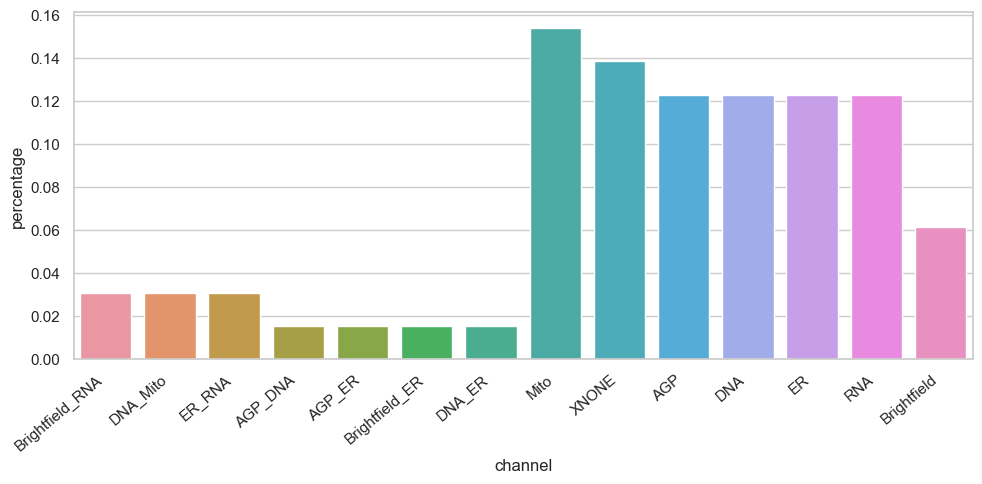

In [37]:
#plot each category of channel based on percentage
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

#convert channel_list to a dataframe
df_channel=pd.DataFrame(channel_list,columns=['channel'])

#count the number of each category
df_channel_count=df_channel.groupby('channel').size().reset_index(name='counts')

#calculate the percentage of each category
df_channel_count['percentage']=df_channel_count['counts']/df_channel_count['counts'].sum()

#sort channel column based on whether it has a specific string "_"
df_channel_count['sort']=df_channel_count['channel'].str.contains('_')
#sort df_channel_count based on the sort column
df_channel_count=df_channel_count.sort_values(by=['sort','percentage'],ascending=False)
#plot the percentage of each category
plt.figure(figsize=(10,5))
ax = sns.barplot(x="channel", y="percentage", data=df_channel_count)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()